Epoch 0, Loss: 7411685888.0
Epoch 100, Loss: 7410011136.0
Epoch 200, Loss: 7408604160.0
Epoch 300, Loss: 7407248384.0
Epoch 400, Loss: 7405912064.0
Epoch 500, Loss: 7404588032.0
Epoch 600, Loss: 7403270144.0
Epoch 700, Loss: 7401958400.0
Epoch 800, Loss: 7400648192.0
Epoch 900, Loss: 7399345664.0
Epoch 1000, Loss: 7398039040.0
Epoch 1100, Loss: 7396737536.0
Epoch 1200, Loss: 7395442176.0
Epoch 1300, Loss: 7394196992.0
Epoch 1400, Loss: 7392844288.0
Epoch 1500, Loss: 7391550464.0
Epoch 1600, Loss: 7390257152.0
Epoch 1700, Loss: 7388967424.0
Epoch 1800, Loss: 7387676672.0
Epoch 1900, Loss: 7386406400.0
Epoch 2000, Loss: 7385111040.0
Epoch 2100, Loss: 7383819776.0
Epoch 2200, Loss: 7382526976.0
Epoch 2300, Loss: 7381348352.0
Epoch 2400, Loss: 7379966976.0
Epoch 2500, Loss: 7378683904.0
Epoch 2600, Loss: 7377819648.0
Epoch 2700, Loss: 7376111104.0
Epoch 2800, Loss: 7374848000.0
Epoch 2900, Loss: 7373555712.0
Epoch 3000, Loss: 7372289536.0
Epoch 3100, Loss: 7371243008.0
Epoch 3200, Loss: 73

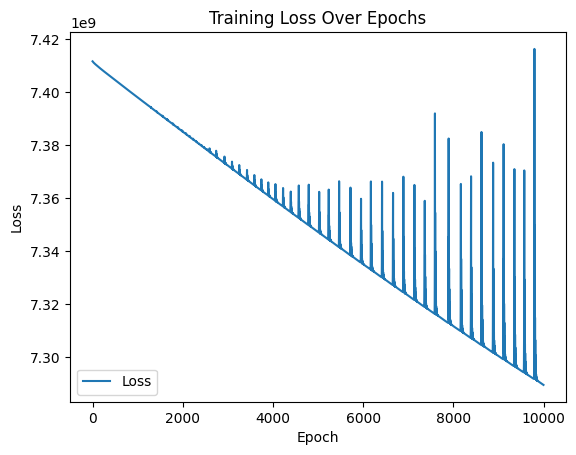

Estimated Parameters:
Beta_1: -0.013717861846089363
Beta_2: 0.008489948697388172
Gamma_1: -6.718414783477783
Gamma_2: -1.1553653478622437
Gamma_3: -0.2705250084400177
Kappa_1: 0.7151594161987305
Kappa_2: 0.16736610233783722
Mu: 2.5555053071002476e-05


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the neural network representing S, A, I, R, D and the parameters
define_PINN_output_size = 13  # 5 compartments (S, A, I, R, D) and 8 time-varying parameters

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, define_PINN_output_size)
        )

    def forward(self, t):
        return self.hidden(t)

# Loss function incorporating residuals from ODEs and data matching
def loss_function(model, t, data):
    # Pass time t through the model
    output = model(t)
    S, A, I, R, D = output[:, 0], output[:, 1], output[:, 2], output[:, 3], output[:, 4]
    beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu = output[:, 5], output[:, 6], output[:, 7], output[:, 8], output[:, 9], output[:, 10], output[:, 11], output[:, 12]

    # Calculate derivatives with respect to time
    dS_dt = torch.autograd.grad(S.sum(), t, create_graph=True)[0]
    dA_dt = torch.autograd.grad(A.sum(), t, create_graph=True)[0]
    dI_dt = torch.autograd.grad(I.sum(), t, create_graph=True)[0]
    dR_dt = torch.autograd.grad(R.sum(), t, create_graph=True)[0]
    dD_dt = torch.autograd.grad(D.sum(), t, create_graph=True)[0]

    # Define the residuals for each equation
    residual_S = dS_dt - (-(beta_1 * S * A) - (beta_2 * S * I) - mu * S)
    residual_A = dA_dt - (beta_1 * S * A - (gamma_1 + gamma_2 + gamma_3) * A - mu * A)
    residual_I = dI_dt - (beta_2 * S * I + gamma_1 * A - (kappa_1 + kappa_2) * I - mu * I)
    residual_R = dR_dt - (gamma_2 * A + kappa_1 * I - mu * R)
    residual_D = dD_dt - (gamma_3 * A + kappa_2 * I)

    # Loss from ODE residuals
    residual_loss = (residual_S ** 2).mean() + (residual_A ** 2).mean() + (residual_I ** 2).mean() + (residual_R ** 2).mean() + (residual_D ** 2).mean()

    # Data matching loss (if data is provided)
    data_loss = 0
    if data is not None:
        S_data, A_data, I_data, R_data, D_data = data
        data_loss = ((S - S_data) ** 2).mean() + ((A - A_data) ** 2).mean() + ((I - I_data) ** 2).mean() + ((R - R_data) ** 2).mean() + ((D - D_data) ** 2).mean()

    # Total loss
    total_loss = residual_loss + data_loss
    return total_loss

# Training loop
def train_PINN(model, t_train, data_train, epochs=10000, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = loss_function(model, t_train, data_train)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Plot loss history
    plt.figure()
    plt.plot(range(epochs), loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

    # Display estimated parameters
    model.eval()
    with torch.no_grad():
        estimated_params = model(t_train)
        beta_1, beta_2, gamma_1, gamma_2, gamma_3, kappa_1, kappa_2, mu = estimated_params[:, 5], estimated_params[:, 6], estimated_params[:, 7], estimated_params[:, 8], estimated_params[:, 9], estimated_params[:, 10], estimated_params[:, 11], estimated_params[:, 12]
        print("Estimated Parameters:")
        print(f"Beta_1: {beta_1.mean().item()}\nBeta_2: {beta_2.mean().item()}\nGamma_1: {gamma_1.mean().item()}\nGamma_2: {gamma_2.mean().item()}\nGamma_3: {gamma_3.mean().item()}\nKappa_1: {kappa_1.mean().item()}\nKappa_2: {kappa_2.mean().item()}\nMu: {mu.mean().item()}")

# Load China's real data
def load_china_data():
    data = pd.read_csv('China_edited_data.csv')
    
    # Convert observation date to datetime and sort
    data['Observation Date'] = pd.to_datetime(data['Observation Date'], format='%d-%m-%Y')
    data = data.sort_values(by='Observation Date')
    
    # Group by observation date and sum the values for confirmed, deaths, and recovered
    grouped = data.groupby('Observation Date').sum()
    
    # Extract time-series data for confirmed, deaths, and recovered
    confirmed = grouped['Confirmed'].values
    deaths = grouped['Deaths'].values
    recovered = grouped['Recovered'].values
    
    # Approximate the compartments
    S_data = 1e5 - confirmed - recovered - deaths  # Approximation for susceptible
    A_data = confirmed * 0.1  # Assuming 10% of confirmed cases are asymptomatic
    I_data = confirmed - A_data
    R_data = recovered
    D_data = deaths
    
    # Convert to torch tensors
    S_data = torch.tensor(S_data, dtype=torch.float32).view(-1, 1)
    A_data = torch.tensor(A_data, dtype=torch.float32).view(-1, 1)
    I_data = torch.tensor(I_data, dtype=torch.float32).view(-1, 1)
    R_data = torch.tensor(R_data, dtype=torch.float32).view(-1, 1)
    D_data = torch.tensor(D_data, dtype=torch.float32).view(-1, 1)
    
    return S_data, A_data, I_data, R_data, D_data

# Example usage
if __name__ == "__main__":
    # Time points for training
    t_train = torch.linspace(0, 51, 51).view(-1, 1).requires_grad_(True)  # Assuming daily data for 41 days
    
    # Load China's real data
    S_data, A_data, I_data, R_data, D_data = load_china_data()
    data_train = (S_data, A_data, I_data, R_data, D_data)
    
    # Initialize model and train
    model = PINN()
    train_PINN(model, t_train, data_train)